In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [82]:
class SigmoidScaleBias(nn.Module):
    def __init__(self, dim, scale=True, bias=True, single_param=False):
        super().__init__()
        if bias:
            self.bias = nn.Parameter(-torch.ones(1 if single_param else dim) * 10.)
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)
        if scale:
            self.scale = nn.Parameter(torch.ones(1 if single_param else dim))
        else:
            self.register_parameter('scale', None)
        
        if self.bias is not None:
            self.bias.data.uniform_(0, 0)

        if self.scale is not None:
            self.scale.data.uniform_(1, 1)

    def forward(self, input):
        output = input
        if self.scale is not None:
            output *= self.scale.unsqueeze(0).expand_as(output)
        if self.bias is not None:
            output -= self.bias.unsqueeze(0).expand_as(output)
        return torch.sigmoid(output)

In [88]:
class OutHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigm = SigmoidScaleBias(2, single_param=True)
        self.out_scale = nn.Parameter(torch.ones(1))
        self.out_th = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        left_right = x
        return self.out_scale * torch.min(left_right, dim=1).values * torch.prod(self.sigm(left_right), dim=1) - self.out_th
        #return self.out_scale * left_right.sum(dim=1) - self.out_th

In [71]:
data = np.load('ds_sim.npz')
X = torch.tensor(data['X'])
Y = torch.tensor(data['Y'])

In [72]:
X.shape

torch.Size([61200, 2])

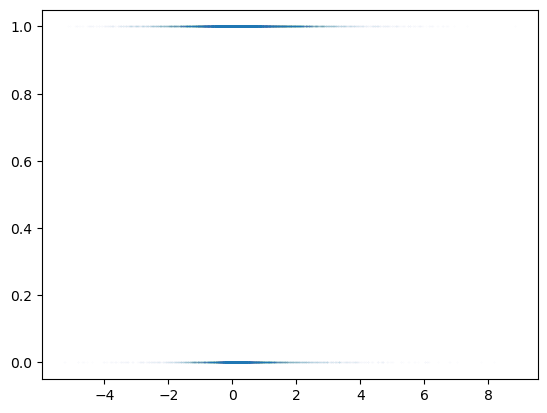

In [73]:
plt.plot(X[:,0]+X[:,1], Y, '.', alpha=0.01, markeredgewidth=0, markersize=3)
plt.show()

In [74]:
train_data = torch.utils.data.TensorDataset(X, Y)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [89]:
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.MSELoss()

N_EPOCHS = 20

model = OutHead().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_losses = []

for epoch in range(N_EPOCHS):
    model.train()
    
    train_loss = 0

    for i, (X_batch, Y_batch) in enumerate(train_loader):
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        optimizer.zero_grad()
        
        Y_pred = model(X_batch)
        
        loss = loss_fn(Y_pred.flatten(), Y_batch.double())
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= (i + 1) # divide by number of batches
    
    print(f'Epoch {epoch}, Loss: {train_loss}')

    train_losses.append(train_loss)


Epoch 0, Loss: 0.6878721079027035
Epoch 1, Loss: 0.68460118893242
Epoch 2, Loss: 0.6838399303351359
Epoch 3, Loss: 0.6834606415748908
Epoch 4, Loss: 0.6833092149857738
Epoch 5, Loss: 0.683010772288711
Epoch 6, Loss: 0.6830948857245783
Epoch 7, Loss: 0.6830221425054619
Epoch 8, Loss: 0.6828739437760442
Epoch 9, Loss: 0.6829716940210248
Epoch 10, Loss: 0.6829478427351827
Epoch 11, Loss: 0.6828996528152389
Epoch 12, Loss: 0.68286948522877
Epoch 13, Loss: 0.6828350543344339
Epoch 14, Loss: 0.6828745317014142
Epoch 15, Loss: 0.6828102842293561
Epoch 16, Loss: 0.682812917561805
Epoch 17, Loss: 0.6827409947505368
Epoch 18, Loss: 0.6828537584620383
Epoch 19, Loss: 0.6827721156425908


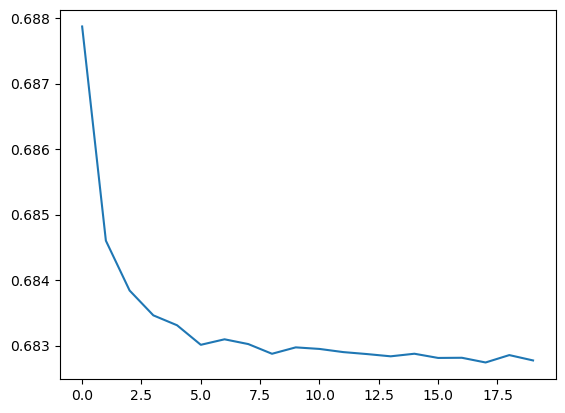

In [90]:
plt.plot(train_losses)
plt.show()